## Part 1: Data Processing

### Process both time series and gamma phase-amplitude coupling (GPAC) images into dataframes

In [1]:
import mne
import numpy as np
import os
import pandas as pd
import scipy.io as sio

from IPython.display import display

mne.set_log_level('ERROR')

In [2]:
NO_LABEL = "No Label"
BASELINE = "Baseline"
BLINK = "Blink"
ELECTRODE_MOVEMENT = "Electrode Movement"
HAND_MOVEMENT = "Hand Movement"
EYE_MOVEMENT = "Eye Movement"

LABELS = {
    # START DO NOT CHANGE, THESE MATCH SUPERVISOR DATA
    NO_LABEL: -1,
    BASELINE: 0,
    BLINK: 1,
    ELECTRODE_MOVEMENT: 2,
    HAND_MOVEMENT: 3,
    ## END
    EYE_MOVEMENT: 4,
}

LABEL_NAMES = { label: name for name, label in LABELS.items() }

In [3]:
def process_timeseries_data(path):
    """ Reads and processes all time series data from MATLAB files in the provided
    path. Only relevant data will be stored for use here.
    """
    all_data = {}

    for file_name in os.listdir(path):
        # 'data' will contain all relevant data that should be used for training.
        # Other keys will hold other useful information that shouldn't be directly
        # needed for training.
        data = {'data': {}}
        
        full_file_path = os.path.join(path, file_name)
        mat_data = sio.loadmat(full_file_path)

        # Time series data with size equal to the number of channels (i.e. electrodes).
        # The electrode names can be indexed to find the electrode that a specific
        # value in this time series data belongs to.
        data['data']['samples'] = list(np.swapaxes(np.array(mat_data['Data']), 0, 1))

        # Time points in seconds
        data['data']['time'] = np.array(mat_data['Time'][0])

        data['data'] = pd.DataFrame(data['data'])
        
        # List of electrode names following the 10-20 EEG recording system
        data['electrodes'] = np.array([item.item() for item in mat_data['Electrodes'][0]])

        all_data[full_file_path] = data

    return all_data


def process_gpac_image_data(path):
    """ Reads and processes all GPAC image data from MATLAB files in the provided
    path. Only relevant data will be stored for use here.
    """
    all_data = {}

    for file_name in os.listdir(path):
        # 'data' will contain all relevant data that should be used for training.
        # Other keys will hold other useful information that shouldn't be directly
        # needed for training.
        data = {'data': {}}
        
        full_file_path = os.path.join(path, file_name)
        mat_data = sio.loadmat(full_file_path)

        # Sample point number corresponding to the start of each 2s window
        data['data']['window_start'] = np.array(mat_data['data']['wind'][0][0][0])

        # GPAC data of size lf x hf, where lf and hf are the dimensions of the GPAC image
        # Note that each window has its data flattened to one list of size lf x hf. We need
        # to cast the reshaped data as a list so that, for this column, each row contains a
        # list of the lf x hf data.
        data['data']['fv'] = np.array(mat_data['data']['fv'][0][0])
        data['data']['fv'] = list(data['data']['fv'].reshape(data['data']['fv'].shape[0], -1))

        # Window labels: baseline interictal (0), blink (1), movement (2), or EMG (3). -1
        # means the window wasn't labelled.
        data['data']['label'] = np.squeeze(np.array(mat_data['training_labels']), axis=1)

        data['data'] = pd.DataFrame(data['data'])

        # The duration of the window chosen for analysis, which should always be 2s
        data['window_len'] = np.array(mat_data['ws'][0])
        
        # lf and hf are the frequency values corresponding to the phase range and amplitude
        # range of interest in the GPAC feature, respectively.
        data['lf'] = np.array(mat_data['lf'][0])
        data['hf'] = np.array(mat_data['hf'][0])

        all_data[full_file_path] = data

    return all_data


def process_eye_blinking_data(file_path):
    """ Reads and processes all eye blinking image data from MATLAB files in the provided
    path. Only relevant data will be stored for use here. Dataset parsed in this function
    was obtained from https://www.sciencedirect.com/science/article/pii/S0925231216001569.
    """
    # 'data' will contain all relevant data that should be used for training.
    # Other keys will hold other useful information that shouldn't be directly
    # needed for training.
    all_data = {}
    data = {'data': {}}
    mat_data = sio.loadmat(file_path)

    mat_data = np.concatenate(
        (mat_data['Epochs']['EyeblinkArtifactEpochs'][0,0]['Voluntary'][0,0]['All'][0,0],
        mat_data['Epochs']['EyeblinkArtifactEpochs'][0,0]['Involuntary'][0,0]['All'][0,0]),
        axis=0
    )
    mat_data = np.swapaxes(mat_data, 0, 1)

    # Time series data with size equal to the number of channels (i.e. electrodes).
    # The electrode names can be indexed to find the electrode that a specific
    # value in this time series data belongs to.
    data['data']['samples'] = list(np.array(mat_data.reshape(-1, mat_data.shape[0])))

    # Sample rate is 256Hz
    data['data']['time'] = np.arange(0, len(data['data']['samples']) / 256, 1 / 256)

    data['data'] = pd.DataFrame(data['data'])
    
    data['data']['label'] = LABELS[BLINK]

    # List of electrode names following the 10-20 EEG recording system
    data['electrodes'] = np.array(['FP1', 'FP2', 'F3', 'F4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'P3', 'Pz', 'P4', 'O1', 'O2'])

    all_data[file_path] = data
    return all_data


def process_hand_eye_movement_data(path):
    """ Reads and processes all hand and eye movement data from MATLAB files in the provided
    path. Only relevant data will be stored for use here. Dataset parsed in this function
    was obtained from https://academic.oup.com/gigascience/article/6/7/gix034/3796323.
    """
    all_data = {}

    for file_name in os.listdir(path):
        # 'data' will contain all relevant data that should be used for training.
        # Other keys will hold other useful information that shouldn't be directly
        # needed for training.
        data = {'data': {}}

        full_file_path = os.path.join(path, file_name)
        mat_data = sio.loadmat(full_file_path)
        
        #
        # ------------ HAND MOVEMENT ------------
        #
        movement_events = mat_data["eeg"]["movement_event"][0][0][0]

        # Indices that indicate when left or right hand movement begins. This movement lasts for 3 seconds, thus
        # movement indices are created by creating a range from <start> to <start + 3> seconds for each index.
        # These indices are the same for both the left and right hand movements.
        num_time_points_per_window = mat_data["eeg"]["srate"][0][0].item() * 3
        movement_start_indices, = np.where(movement_events == 1)
        movement_indices = np.array(np.ravel([np.arange(start, start + num_time_points_per_window) for start in movement_start_indices]))

        # All non-movement data is baseline, so set all labels to baseline and replace movement indices with movement labels
        labels = np.full(len(movement_events), LABELS[BASELINE])
        labels[movement_indices] = LABELS[HAND_MOVEMENT]
        
        # Same movement indices for both left and right hand, so concatenate the arrays twice
        labels = np.concatenate((labels, labels))

        # Movement events specified for both left and right, so multiply length by 2
        sample_rate = mat_data["eeg"]["srate"][0][0].item()
        time = np.arange(0, len(movement_events) * 2 / sample_rate, 1 / sample_rate)

        # The data contains 64 EEG channels and 4 EMG channels, take only the EEG channels.
        # Data for both left and right hands is concatenated after extracting relevant data
        # according to the movement indices.
        data['data']['samples'] = list(np.concatenate(
            [np.array(np.swapaxes(mat_data["eeg"][movement][0][0][:64], 0, 1)) for movement in ["movement_left", "movement_right"]]
        ))

        data['data']['time'] = time
        data['data']['label'] = labels

        data['data'] = pd.DataFrame(data['data'])

        #
        # ------------ EYE MOVEMENT ------------
        #
        eye_samples = list(np.concatenate(
            [np.array(np.swapaxes(mat_data["eeg"]["noise"][0,0][i][0][:64], 0, 1)) for i in range(1, 3)]
        ))
        # Appending to end of hand movement, so start time right after previous time ends
        eye_start_time = time[-1] + 1 / sample_rate

        # 20s worth of data (10s for each type of eye movement)
        eye_time = np.arange(eye_start_time, eye_start_time + 20, 1 / sample_rate)
        eye_labels = np.full(len(eye_samples), LABELS[EYE_MOVEMENT])

        eye_df = pd.DataFrame({'samples': eye_samples, 'time': eye_time, 'label': eye_labels})
        data['data'] = pd.concat([data['data'], eye_df], ignore_index=True)

        all_data[full_file_path] = data
    
    return all_data


def process_eye_data(path):
    """
    Reads and processes all eye (blink + movement) data from MATLAB files in the provided
    path. Stores in the dict all_data which is indexed by path directly to the data
    file. Dataset parsed in this function was obtained from https://osf.io/8xwv2/.
    """
    all_data = {}
    
    for dirs in os.listdir(path):
        
        if os.path.isdir(os.path.join(path, dirs)):
            file_path = os.path.join(path, dirs)
            
            for file_name in os.listdir(file_path):
                # We only read the .set files as they contain the time-series data
                if file_name.endswith('.set'):
                    # Read the .set file and convert into a pandas dataframe
                    data = mne.io.read_epochs_eeglab(os.path.join(file_path, file_name))
                    data_df = data.to_data_frame()
                    
                    # Filter out some of the channels, MISSING FP1 and FP2
                    # Note: to select different channels for dataframe, just modify this list
                    channels_to_keep = ['time','FPz', 'F3', 'F4','T7','C3','Cz','C4','T8','P3','Pz','P4','O1', 'O2', 'artifactclasses']

                    # Some datasets did not have all the desired columns, so this is a check
                    if set(channels_to_keep).issubset(data_df.columns): 
                        data_df = data_df[channels_to_keep]
                        data = {}

                        # Convert time in ms to s
                        data_df['time'] = np.arange(len(data_df)) * 5 / 1000

                        data_df['artifactclasses'] = np.where((data_df.artifactclasses == 0), LABELS[NO_LABEL], data_df.artifactclasses)
                        data_df['artifactclasses'] = np.where((data_df.artifactclasses <= 4) & (data_df.artifactclasses >= 1), LABELS[EYE_MOVEMENT], data_df.artifactclasses)
                        data_df['artifactclasses'] = np.where((data_df.artifactclasses == 5), LABELS[BLINK], data_df.artifactclasses)
                        data_df['artifactclasses'] = np.where((data_df.artifactclasses == 6), LABELS[BASELINE], data_df.artifactclasses)
                        
                        data_df = data_df.rename(columns={'artifactclasses' : 'label'})
                        data_df['label'] = data_df['label'].apply(np.int32)
                        
                        # Convert all of the EEG channel data columns into a list, and create a column for that data
                        eeg_channels = ['FPz', 'F3', 'F4','T7','C3','Cz','C4','T8','P3','Pz','P4','O1', 'O2']
                        data_df['samples'] = data_df[eeg_channels].values.tolist()

                        # Remove the individual EEG channel columns,
                        for col in eeg_channels:
                            del data_df[col]

                        data_df = data_df[['samples', 'time', 'label']]
                            
                        data['data'] = data_df
                        data['electrodes'] = eeg_channels
             
                        full_file_path = os.path.join(file_path, file_name)
                        all_data[full_file_path] = data
    
    return all_data

In [4]:
# Read all relevant data from the MATLAB files
BASE_DATA_PATH = "data"
TIME_SERIES_DATA_PATH = os.path.join(BASE_DATA_PATH, "TimeSeries")
GPAC_IMAGES_DATA_PATH = os.path.join(BASE_DATA_PATH, "GPAC_Images_Labelled")
EYE_BLINKING_DATA_PATH = os.path.join(BASE_DATA_PATH, "Voluntary_Involuntary_Eye_Blinks", "Epochs.mat")
HAND_EYE_MOVEMENT_DATA_PATH = os.path.join(BASE_DATA_PATH, "Left_Right_Hand_MI", "mat_data")
EYE_DATA_PATH = os.path.join(BASE_DATA_PATH, 'EEG_Eye_Artifacts')

timeseries_data = process_timeseries_data(TIME_SERIES_DATA_PATH)
print("Loaded time-series data")
gpac_image_data = process_gpac_image_data(GPAC_IMAGES_DATA_PATH)
print("Loaded GPAC image data")
eye_blinking_data = process_eye_blinking_data(EYE_BLINKING_DATA_PATH)
print("Loaded eye blinking data")
hand_eye_movement_data = process_hand_eye_movement_data(HAND_EYE_MOVEMENT_DATA_PATH)
print("Loaded hand/eye movement data")
eye_data = process_eye_data(EYE_DATA_PATH)
print("Loaded eye data")

Loaded time-series data
Loaded GPAC image data
Loaded eye blinking data
Loaded hand/eye movement data
Loaded eye data


In [5]:
# Get some test data to show data structure
test_timeseries_data = next(iter(timeseries_data.values()))
test_gpac_data = next(iter(gpac_image_data.values()))
test_eye_blinking_data = next(iter(eye_blinking_data.values()))
test_hand_eye_movement_data = next(iter(hand_eye_movement_data.values()))
test_eye_data = next(iter(eye_data.values()))

In [6]:
# Time series data
print("---------- TIME SERIES DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_timeseries_data['data'])

print("\n\nElectrode Names:")
display(test_timeseries_data['electrodes'])

print(f"\n\nNumber of Channels Per Sample: {len(test_timeseries_data['data']['samples'][0])}")


# GPAC image data
print("\n\n\n---------- GPAC IMAGE DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_gpac_data['data'])

print(f"\n\nWindow Length (seconds): {test_gpac_data['window_len'].item()}")

print("\n\nPhase Range Of Interest:")
display(test_gpac_data['lf'])

print("\n\nAmplitude Range Of Interest:")
display(test_gpac_data['hf'])

print(f"\n\nNumber of Datapoints Per GPAC Image: {len(test_gpac_data['data']['fv'][0])}")


# Eye blinking data
print("\n\n\n---------- EYE BLINKING DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_eye_blinking_data['data'])

print("\n\nElectrode Names:")
display(test_eye_blinking_data['electrodes'])

print(f"\n\nNumber of Channels Per Sample: {len(test_eye_blinking_data['data']['samples'][0])}")


# Hand and eye movement data
print("\n\n\n---------- HAND/EYE MOVEMENT DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_hand_eye_movement_data['data'])

print(f"\n\nNumber of Channels Per Sample: {len(test_hand_eye_movement_data['data']['samples'][0])}")


# Eye data (blink + movement)
print("\n\n\n---------- EYE DATA FORMAT ----------")

print("\n\nData For Training:")
display(test_eye_data['data'])

print("\n\nElectrode Names:")
display(test_eye_data['electrodes'])

print(f"\n\nNumber of Channels Per Sample: {len(test_eye_data['data']['samples'][0])}")

---------- TIME SERIES DATA FORMAT ----------


Data For Training:


,samples,time
0,"[6.108219724308253e-05, 4.1935847751014113e-05...",0.000
1,"[6.0519399017154524e-05, 4.2618500927900726e-0...",0.002
2,"[6.742417259467301e-05, 4.1556992611811064e-05...",0.004
3,"[5.537121535626189e-05, 4.2360979111764424e-05...",0.006
4,"[5.912841684511108e-05, 4.846190553369728e-05,...",0.008
...,...,...
949494,"[-3.11911321717285e-05, 2.3324337114086137e-05...",1898.988
949495,"[-2.9876694427662773e-05, 2.2369713074451038e-...",1898.990
949496,"[-3.09238426711861e-05, 2.1764404072353062e-05...",1898.992
949497,"[-3.018560838381861e-05, 1.9767057467827266e-0...",1898.994




Electrode Names:


array(['FP1', 'F3', 'C3', 'P3', 'O1', 'F7', 'T3', 'T5', 'F9', 'T9', 'P9',
       'Fz', 'Cz', 'Pz', 'FP2', 'F8', 'T4', 'T6', 'O2', 'F4', 'C4', 'P4',
       'F10', 'T10', 'P10'], dtype='<U3')



Number of Channels Per Sample: 25



---------- GPAC IMAGE DATA FORMAT ----------


Data For Training:


,window_start,fv,label
0,1436.0,"[0.025656345787360417, 0.032179734517346216, 0...",0
1,2436.0,"[0.025213492886223276, 0.025289140962647953, 0...",3
2,3436.0,"[0.023487781808931615, 0.01826561582104771, 0....",1
3,4436.0,"[0.06850261987711749, 0.07487524108974554, 0.0...",2
4,5436.0,"[0.028818125484047188, 0.02471954469685771, 0....",0
...,...,...,...
941,942436.0,"[0.02258746497266887, 0.018580595931532815, 0....",-1
942,943436.0,"[0.03575053160503277, 0.03564018155802227, 0.0...",-1
943,944436.0,"[0.030996596628728112, 0.028858710017469907, 0...",-1
944,945436.0,"[0.030891367009021852, 0.030663095755187705, 0...",-1




Window Length (seconds): 2


Phase Range Of Interest:


array([ 1. ,  1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,
        2.1,  2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,
        3.2,  3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,
        4.3,  4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,
        5.4,  5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,
        6.5,  6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,
        7.6,  7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,
        8.7,  8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,
        9.8,  9.9, 10. ])



Amplitude Range Of Interest:


array([ 20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,
        33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,
        46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,
        72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149,
       150], dtype=int64)



Number of Datapoints Per GPAC Image: 11921



---------- EYE BLINKING DATA FORMAT ----------


Data For Training:


,samples,time,label
0,"[9.709728321448466, 11.525812172656526, 13.811...",0.000000,1
1,"[13.009598524570704, 13.692492531665714, 13.11...",0.003906,1
2,"[9.744855775183703, 11.290155037317742, 12.201...",0.007812,1
3,"[40.81332724299266, 49.899748469388484, 62.085...",0.011719,1
4,"[151.66833596629317, 157.53203247940522, 159.1...",0.015625,1
...,...,...,...
893947,"[-0.07466539432252636, -0.33331168671831746, -...",3491.980469,1
893948,"[-0.7983416909075477, -0.6307943974575243, -0....",3491.984375,1
893949,"[-1.0631469307127797, -0.9587214956166292, -0....",3491.988281,1
893950,"[-0.4765436059788351, -0.570592790940478, -0.5...",3491.992188,1




Electrode Names:


array(['FP1', 'FP2', 'F3', 'F4', 'T3', 'C3', 'Cz', 'C4', 'T4', 'P3', 'Pz',
       'P4', 'O1', 'O2'], dtype='<U3')



Number of Channels Per Sample: 14



---------- HAND/EYE MOVEMENT DATA FORMAT ----------


Data For Training:


,samples,time,label
0,"[-9773.996, -168767.25, -168224.25, 393200.5, ...",0.000000,0
1,"[-9950.996, -168754.5, -168037.5, 393191.25, 4...",0.001953,0
2,"[-10090.496, -168889.75, -168162.75, 392958.0,...",0.003906,0
3,"[-9941.496, -168742.25, -168323.75, 392815.0, ...",0.005859,0
4,"[-10098.996, -168829.0, -168639.5, 392680.25, ...",0.007812,0
...,...,...,...
153595,"[-13989.996, -179697.0, -179662.5, 405797.25, ...",299.990234,4
153596,"[-13865.996, -179685.0, -179708.5, 405798.0, 5...",299.992188,4
153597,"[-13569.996, -179238.75, -179500.75, 405935.0,...",299.994141,4
153598,"[-13860.496, -179459.0, -179688.5, 405858.25, ...",299.996094,4




Number of Channels Per Sample: 64



---------- EYE DATA FORMAT ----------


Data For Training:


,samples,time,label
0,"[-6.567975997924805, -6.800750255584717, -5.99...",0.000,0
1,"[1.3263161182403562, -1.3392481803894043, 1.46...",0.005,0
2,"[-3.2663574218749996, -4.810687065124512, -1.7...",0.010,0
3,"[-7.127173900604248, -14.330775260925293, -6.7...",0.015,0
4,"[-0.7186227440834045, -9.71044635772705, -4.88...",0.020,0
...,...,...,...
83195,"[14.36747932434082, 15.524653434753418, 10.427...",415.975,0
83196,"[17.503890991210938, 16.9011287689209, 14.0831...",415.980,0
83197,"[21.33043098449707, 21.137893676757812, 20.868...",415.985,0
83198,"[18.068984985351562, 21.00862121582031, 21.293...",415.990,0




Electrode Names:


['FPz', 'F3', 'F4', 'T7', 'C3', 'Cz', 'C4', 'T8', 'P3', 'Pz', 'P4', 'O1', 'O2']



Number of Channels Per Sample: 13


In [7]:
def label_time_series(all_time_series, all_gpac, gpac_data_path):
    """
    Fucntion that will translate the labels from the GPAC Dataframe to the Time-Series DataFrame 
    """
    labelled_time_series = {}

    for file_path, time_series in all_time_series.items():
        gpac = all_gpac[os.path.join(gpac_data_path, os.path.basename(file_path))] 

        # Initial label value for all rows in the time_series
        time_series['data']['label'] = LABELS[NO_LABEL]

        # Iterate through the GPAC rows to obtain the window value and the label 
        for index, row in gpac['data'].iterrows():
            window_start = int(row['window_start'])
            label_value = row['label']
            
            # Set the 'label' value for the time series Dataframe
            # Add 1000 to window_start because in time_series it is separated by intervals of 0.002 s.
            # 1 window size = 2s, 2 / 0.002 = 1000 rows 
            time_series['data'].loc[window_start : window_start+1000, 'label'] = label_value
        
        labelled_time_series[file_path] = time_series
    
    return labelled_time_series
    
timeseries_data_labelled = label_time_series(timeseries_data, gpac_image_data, GPAC_IMAGES_DATA_PATH)
test_timeseries_data_labelled = next(iter(timeseries_data_labelled.values()))

print("\n\nAs seen in the GPAC Dataframe in the previous cell, the label begins at t=1436, and below you can see that change:")
display(test_timeseries_data_labelled['data'].iloc[1433:1439])

print("\n\nSimilarly, the second label begins at t=2436, and below you can see that change:")
display(test_timeseries_data_labelled['data'].iloc[2433:2439])

print("\n\nLabel value statistics of the time-series data:")
print(test_timeseries_data_labelled['data']['label'].value_counts())

print("\n\nLabel value statistics of the GPAC data:")
print(test_gpac_data['data']['label'].value_counts())



As seen in the GPAC Dataframe in the previous cell, the label begins at t=1436, and below you can see that change:


,samples,time,label
1433,"[-3.918726818570923e-05, 3.1590051061025356e-0...",2.866,-1
1434,"[-2.7482217912228493e-05, 3.294411591614816e-0...",2.868,-1
1435,"[-3.871242545568842e-05, 3.251909070927831e-05...",2.870,-1
1436,"[-4.014147248365788e-05, 3.043857439682265e-05...",2.872,0
1437,"[-3.478690402970244e-05, 3.202987604497138e-05...",2.874,0
1438,"[-3.337380150125322e-05, 3.7954873986926406e-0...",2.876,0




Similarly, the second label begins at t=2436, and below you can see that change:


,samples,time,label
2433,"[6.336374464748228e-05, 6.706071296848414e-05,...",4.866,0
2434,"[5.307997547277073e-05, 6.623601097400111e-05,...",4.868,0
2435,"[5.416560886950276e-05, 6.953586163041345e-05,...",4.870,0
2436,"[6.708489008597993e-05, 7.019486785538814e-05,...",4.872,3
2437,"[7.915946937218587e-05, 7.136690139654629e-05,...",4.874,3
2438,"[7.392872574665033e-05, 7.387425424376896e-05,...",4.876,3




Label value statistics of the time-series data:
-1    889499
 3     15000
 2     15000
 1     15000
 0     15000
Name: label, dtype: int64


Label value statistics of the GPAC data:
-1    886
 3     15
 2     15
 1     15
 0     15
Name: label, dtype: int64


In [8]:
# Determines time in seconds of each type of label
def update_seconds_counts(df):
    sample_rate_inv = df['data']['time'][1] - df['data']['time'][0]

    # Count number of rows of each label in the data, then get
    # number of seconds by dividing by the sample rate.
    counts = df['data'].groupby('label').size()
    for label in counts.index:
        seconds_counts[label] += counts[label] * sample_rate_inv

datasets = [
    timeseries_data_labelled,
    eye_blinking_data,
    hand_eye_movement_data,
    eye_data
]

seconds_counts = { label: 0 for label in LABEL_NAMES.keys() }

for dataset in datasets:
    for file_path, data in dataset.items():
        update_seconds_counts(data)

print("Amount of Data Per Label")
print("------------------------")
for label, seconds in seconds_counts.items():
    print(f"{LABEL_NAMES[label]}: {seconds_counts[label]:.3f}s")

Amount of Data Per Label
------------------------
No Label: 16080.795s
Baseline: 12179.812s
Blink: 4546.257s
Electrode Movement: 510.002s
Hand Movement: 6750.000s
Eye Movement: 4513.410s


## Part 2: Data Transform

In [9]:
import numpy as np
import pywt
import scipy

def do_cwt(X,freq,fs,wavename = 'cmor5-0.8125'):
    """Computes complex wavelet transform for EEG data

    Parameters
    ----------
    X : input data
    freq : input frequency range eg. 0.25:0.25:50
    fs : sampling frequency
    wavename : The default is 'cmor5-0.8125'.

    Returns
    -------
    cwt complex coefficients
    frequency range
    time
    """
    T = 1.0/fs
    t = np.arange(0,len(X)*T,T)
    a_coef = pywt.centrfrq(wavename)* (1.0/(freq*T))
    
    # calculate the wavelet coefficients (distance x frequency x time)
    cwt_c = pywt.cwt(X,a_coef,wavename, method='fft')
    return cwt_c[0], freq, t

def get_all_cwts(X, lf, hf, fs, wavename='cmor5-0.8125'):
    n_samples, n_channels = X.shape
    rCWT_lf = np.zeros((n_channels, np.size(lf), n_samples), dtype=complex)
    rCWT_hf = np.zeros((n_channels, np.size(hf), n_samples), dtype=complex)

    for signal in range(n_channels):
        data_compute = X[:, signal]
        rCWT_lf[signal, :, :], _, _ = do_cwt(data_compute, lf, fs, 'cmor6-0.8125')
        rCWT_hf[signal, :, :], _, _ = do_cwt(data_compute, hf, fs, 'cmor6-0.8125')
    
    return rCWT_lf, rCWT_hf

def do_cwt_scipy(X, freq, fs, w=0.8125):
    """Computes complex wavelet transform for EEG data

    Parameters
    ----------
    X : input data
    freq : input frequency range eg. 0.25:0.25:50
    fs : sampling frequency
    wavename : The default is 'cmor5-0.8125'.

    Returns
    -------
    cwt complex coefficients
    frequency range
    time
    """
    T = 1.0/fs
    t = np.arange(0,len(X)*T,T)
    widths = w*fs / (2*freq*np.pi)

    # calculate the wavelet coefficients (distance x frequency x time)
    print(scipy.__version__)
    cwt_c = scipy.signal.cwt(X, scipy.signal.morlet2, widths, dtype=np.complex128, w=w)
    return cwt_c, freq, t

def do_tort_pac(c1,c2,N=18):
    """Computes phase-amplitude coupling index based on Tort's algorithm

    Parameters
    ----------
    c1 : cwt coefficients for phase frequencies
    c2 : cwt coefficients for amplitude frequencies
    N : number of phase bins

    Returns
    -------
    PAC - Phase-Amplitude Coupling Index.

    """
    nphase = c1.shape[0]
    namplitude = c2.shape[0]
    amp = np.abs(c2)
    phi = np.arctan2(np.imag(c1),np.real(c1)) + np.pi
    PAC=np.empty([namplitude,nphase])
    # for idx1 in tqdm(np.arange(nphase)): # TQDM slows down code
    for idx1 in np.arange(nphase):
        for idx2 in np.arange(namplitude):
            phase = phi[idx1,:]
            amplitude = amp[idx2,:]
            rng = 2*np.pi/N
            Afa = np.zeros([N,1])
            for idx3 in np.arange(N):
                ST = (idx3)*rng
                ET = (idx3+1)*rng
                Afa[idx3] = np.mean(amplitude[np.argwhere(np.logical_and(phase>ST, phase<=ET)==True)])
            p = Afa/np.sum(Afa)
            H = -np.sum(p*np.log(p))
            PAC[idx2,idx1] = (np.log(N) - H)/np.log(N)
    PAC.shape
    PAC[np.isnan(PAC)] = 1
    return PAC


def do_tort_pac_gpu_cupy_complete_vectorized(c1,c2,N=18):
    """
    Computes PAC coupling index using CuPy

    Parameters
    ----------
    c1 : cwt coefficients for phase frequencies, num_channels x num_phase x num_samples
    c2 : cwt coefficients for amplitude frequencies, num_channels x num_amps x num_samples
    N : number of phase bins

    Returns
    -------
    PAC - Phase-Amplitude Coupling Index of all channels
    """

    c1 = cp.asarray(c1)
    c2 = cp.asarray(c2)
    bin_ranges = cp.linspace(0, 2*cp.pi, N + 1)
    n_signals = c1.shape[0] # Number of channels
    n_samples = c1.shape[2] # Length of signal
    n_phases = c1.shape[1] # Number of frequencies of phase signal
    n_amps = c2.shape[1] # Number of frequencies of amplitude signal

    # Compute phases and amplitudes of coefficients
    phase_values = np.tile(cp.angle(c1) + cp.pi, (N, 1, 1, 1)) # num_channels x num_phase x num_samples x N
    amp_values = np.tile(cp.absolute(c2), (N, 1, 1, 1)) # num_channels x num_amps x num_samples x N
    bin_range_1 = bin_ranges[:-1].reshape(N, 1, 1, 1) # Left side of ranges
    bin_range_2 = bin_ranges[1:].reshape(N, 1, 1, 1) # Right side of ranges

    # Bin amplitudes based on phase
    all_phase_amps = cp.zeros((N, n_signals, n_phases, n_amps)) # num_channels x num_bins x num_phases x num_amps
    curr_value = cp.zeros((N, n_signals, n_phases, n_samples)) # Hold binary values of whether phases is in bins, num_channels x num_phase x num_samples
    curr_value[(phase_values > bin_range_1) & (phase_values < bin_range_2)] = 1
    all_phase_amps = cp.einsum('ijkl,ijlm->ijkm', curr_value, cp.transpose(amp_values, (0, 1, 3, 2)))

    # Calculate modulation indices
    PAC = cp.zeros((n_signals, n_phases, n_amps))
    all_phase_amps = all_phase_amps / cp.sum(all_phase_amps, 0).reshape(1, n_signals, n_phases, n_amps)
    all_entropies = -cp.sum(all_phase_amps * cp.log(all_phase_amps), 0) # num_channels x num_phase x num_samples
    all_entropies[cp.isnan(all_entropies)] = 0
    PAC = (cp.log(N) - all_entropies) / cp.log(N)

    return cp.asnumpy(PAC)

def do_tort_pac_numpy(c1,c2,N=18):
    """
    Computes PAC coupling index using Numpy

    Parameters
    ----------
    c1 : cwt coefficients for phase frequencies, num_channels x num_phase x num_samples
    c2 : cwt coefficients for amplitude frequencies, num_channels x num_amps x num_samples
    N : number of phase bins

    Returns
    -------
    PAC - Phase-Amplitude Coupling Index of all channels
    """
    bin_ranges = np.linspace(0, 2*np.pi, N + 1)
    n_signals = c1.shape[0] # Number of channels
    n_samples = c1.shape[2] # Length of signal
    n_phases = c1.shape[1] # Number of frequencies of phase signal
    n_amps = c2.shape[1] # Number of frequencies of amplitude signal

    # Compute phases and amplitudes of coefficients
    phase_value = np.angle(c1) + np.pi # num_channels x num_phase x num_samples
    amp_values = np.absolute(c2) # num_channels x num_amps x num_samples

    # Bin amplitudes based on phase
    all_phase_amps = np.zeros((n_signals, n_phases, n_amps, N)) # num_channels x num_phases x num_amps x num_bins
    for b in range(N): # Iterate through each bin
        # Hold binary values of whether a phase in in the current bin, num_channels x num_phase x num_samples
        curr_value = np.zeros((n_signals, n_phases, n_samples))
        curr_value[(phase_value > bin_ranges[b]) & (phase_value < bin_ranges[b + 1])] = 1
        all_phase_amps[..., b] = np.einsum('ijk,ikl->ijl', curr_value, np.transpose(amp_values, (0, 2, 1)))

    # Calculate modulation indices
    PAC = np.zeros((n_signals, n_phases, n_amps))
    all_phase_amps = all_phase_amps / np.sum(all_phase_amps, 3).reshape(n_signals, n_phases, n_amps, 1)
    all_entropies = -np.sum(all_phase_amps * np.log(all_phase_amps), 3) # num_channels x num_phase x num_samples
    all_entropies[np.isnan(all_entropies)] = 0
    PAC = (np.log(N) - all_entropies) / np.log(N)

    return PAC

#print(f'Time elapsed: {((time.time()-t)/60)} mins.')

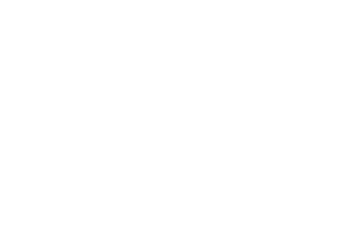

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

def generateTrainingImages(gpacData):
    """ Reads and processes all GPAC data from previous preprocessing and convert the data
    into images in greyscale and in a heatmap.
    """
    plt.axis('off')
    image_dir = os.path.join('data', 'images')
    greyscale_image_dir = os.path.join('data', 'greyscaleimages')

    if not os.path.exists(image_dir):
        os.mkdir(image_dir)
    if not os.path.exists(greyscale_image_dir):
        os.mkdir(greyscale_image_dir)

    for file in gpacData.keys():
        for i, gpac in enumerate(gpacData[file]['data']['fv']):

            # Saves all of the images in a heatmap
            folder = LABEL_NAMES[gpacData[file]['data']['label'][i]]
            if folder != NO_LABEL:
                gpac_img = gpac.reshape(len(gpacData[file]['lf']), len(gpacData[file]['hf']))
                
                folder_image_dir = os.path.join(image_dir, folder)
                folder_greyscale_image_dir = os.path.join(greyscale_image_dir, folder)

                if not os.path.exists(folder_image_dir):
                    os.mkdir(folder_image_dir)
                if not os.path.exists(folder_greyscale_image_dir):
                    os.mkdir(folder_greyscale_image_dir)
                
                # Scale all of the values based on the maximum 
                squared_np = gpac_img / np.amax(gpac_img)
                
                # Pass the image through the cmap to convert 2D numpy array to a 3D numpy array
                cmap = plt.get_cmap('viridis') # 'viridis' is the colour map, don't change this
                rgba_img = cmap(squared_np)
                
                # Construct the RGB image and save
                img = Image.fromarray((rgba_img * 255).astype(np.uint8))
                img.save(os.path.join(folder_image_dir, os.path.basename(file) + f'{i}.png'))
                
                # Construct the grayscale image and save
                gray_img = Image.fromarray((squared_np * 255).astype(np.uint8))
                gray_img.save(os.path.join(folder_greyscale_image_dir, os.path.basename(file) + f'{i}.png'))
                
generateTrainingImages(gpac_image_data)

## Part 3: ML Input-Output Preprocessing

In [11]:
from keras.preprocessing.image import img_to_array, load_img

data = []
labels = []

for image_label in os.scandir(os.path.join('data', 'images')):
    for filename in os.scandir(image_label.path):
        if filename.path.endswith(".png"):
            data.append(img_to_array(load_img(filename.path)))
            labels.append(LABELS[image_label.name])

In [12]:
print(labels[-5:])
print(data[0])


[3, 3, 3, 3, 3]
[[[121. 209.  81.]
  [253. 231.  36.]
  [225. 227.  24.]
  ...
  [ 54.  91. 140.]
  [ 53.  92. 140.]
  [ 54.  90. 140.]]

 [[154. 216.  60.]
  [248. 230.  33.]
  [167. 219.  51.]
  ...
  [ 42. 117. 142.]
  [ 42. 117. 142.]
  [ 42. 118. 142.]]

 [[233. 228.  25.]
  [248. 230.  33.]
  [181. 221.  43.]
  ...
  [ 41. 120. 142.]
  [ 41. 121. 142.]
  [ 41. 121. 142.]]

 ...

 [[ 69.   8.  91.]
  [ 69.   6.  90.]
  [ 69.   6.  90.]
  ...
  [ 72.  33. 114.]
  [ 72.  32. 113.]
  [ 72.  32. 113.]]

 [[ 69.   8.  91.]
  [ 69.   8.  91.]
  [ 69.   8.  91.]
  ...
  [ 72.  30. 112.]
  [ 72.  30. 112.]
  [ 72.  32. 113.]]

 [[ 70.   9.  92.]
  [ 69.   8.  91.]
  [ 69.   8.  91.]
  ...
  [ 72.  29. 111.]
  [ 72.  29. 111.]
  [ 72.  29. 111.]]]


In [13]:
df = pd.DataFrame(list(zip(data, labels)), 
               columns =['data', 'labels']) 
display(df)

,data,labels
0,"[[[121.0, 209.0, 81.0], [253.0, 231.0, 36.0], ...",0
1,"[[[207.0, 225.0, 28.0], [170.0, 219.0, 50.0], ...",0
2,"[[[33.0, 166.0, 133.0], [30.0, 159.0, 136.0], ...",0
3,"[[[44.0, 177.0, 125.0], [38.0, 172.0, 129.0], ...",0
4,"[[[136.0, 213.0, 71.0], [139.0, 213.0, 70.0], ...",0
...,...,...
1014,"[[[64.0, 67.0, 135.0], [63.0, 71.0, 136.0], [6...",3
1015,"[[[69.0, 53.0, 128.0], [65.0, 65.0, 134.0], [5...",3
1016,"[[[42.0, 119.0, 142.0], [42.0, 117.0, 142.0], ...",3
1017,"[[[35.0, 137.0, 141.0], [57.0, 185.0, 118.0], ...",3


In [14]:
df = df.sample(frac=1).reset_index(drop=True)

## Part 4: ML Model (Baseline)

In [15]:
from keras.utils import np_utils
from sklearn.utils import shuffle

X, y = shuffle(data, labels, random_state=0)

X_train = X[:int(len(X)*0.7)]
X_test = X[int(len(X)*0.7):]

y_train = y[:int(len(y)*0.7)]
y_test = y[int(len(y)*0.7):]

print(y_train[0])
print(X_train[0].shape)

# Width and height of image data
HEIGHT, WIDTH = X_train[0].shape[:2]

X_train = np.array(X_train).reshape(len(X_train), WIDTH, HEIGHT, 3).astype('float32')
X_test = np.array(X_test).reshape(len(X_test), WIDTH, HEIGHT, 3).astype('float32')

y_train = np.array(y_train)
y_test = np.array(y_test)

# one-hot encoding using keras' numpy-related utilities
###
n_classes = 4 # TODO: NEEDS TO BE CHANGED ONCE NEW DATA IS INCORPORATED INTO THE MODEL
###
print("Shape before one-hot encoding: ", y_train.shape)
y_train = np_utils.to_categorical(y_train, n_classes)
y_test = np_utils.to_categorical(y_test, n_classes)
print("Shape after one-hot encoding: ", y_train.shape)

1
(91, 131, 3)
Shape before one-hot encoding:  (713,)
Shape after one-hot encoding:  (713, 4)


In [16]:
import tensorflow as tf

from sklearn.metrics import auc, classification_report, roc_curve

def train(model, X_train, y_train, X_test, y_test, n_classes, batch_size=128, epochs=20):
    # Train model and get predictions on testing data
    history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test))
    y_pred = model(X_test).numpy()


    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


    # Create ROC curves
    plt.figure(figsize=(8, 8))
    fpr, tpr, roc_auc = {}, {}, {}

    # Compute micro-average and per-class false/true positive rate and
    # area under the curve.
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot micro-average and per-class ROC curves
    plt.plot(
        fpr["micro"], tpr["micro"],
        label=f'Micro-Average (area = {roc_auc["micro"]:0.2f})'
    )

    for i in range(n_classes):
        plt.plot(
            fpr[i], tpr[i],
            label=f'Class {i}, {LABEL_NAMES[i]} (area = {roc_auc[i]:0.2f})'
        )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()

    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=1), depth=y_pred.shape[-1]).numpy()
    # TODO: when adding new data, the list of target names needs to be updated to exclude electrode movement and include eye movement
    print(classification_report(y_test, y_pred, target_names=[key for key, val in LABELS.items() if val not in [-1, 4]]))

Epoch 1/25
6/6 [==============================] - 4s 597ms/step - loss: 30.1196 - accuracy: 0.2486 - val_loss: 13.4117 - val_accuracy: 0.2484
Epoch 2/25
6/6 [==============================] - 4s 603ms/step - loss: 12.3483 - accuracy: 0.2265 - val_loss: 10.1013 - val_accuracy: 0.2484
Epoch 3/25
6/6 [==============================] - 3s 540ms/step - loss: 6.6686 - accuracy: 0.2352 - val_loss: 3.5201 - val_accuracy: 0.2745
Epoch 4/25
6/6 [==============================] - 3s 536ms/step - loss: 2.8577 - accuracy: 0.2590 - val_loss: 2.7054 - val_accuracy: 0.2516
Epoch 5/25
6/6 [==============================] - 3s 529ms/step - loss: 2.1132 - accuracy: 0.2721 - val_loss: 1.6698 - val_accuracy: 0.3856
Epoch 6/25
6/6 [==============================] - 3s 535ms/step - loss: 1.5086 - accuracy: 0.3118 - val_loss: 1.4604 - val_accuracy: 0.2516
Epoch 7/25
6/6 [==============================] - 3s 542ms/step - loss: 1.4602 - accuracy: 0.3021 - val_loss: 1.3171 - val_accuracy: 0.4085
Epoch 8/25
6/6 [

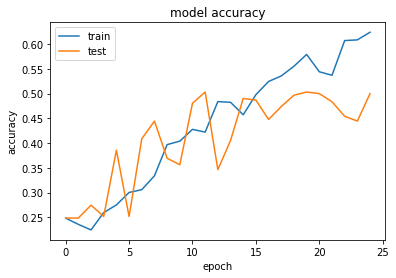

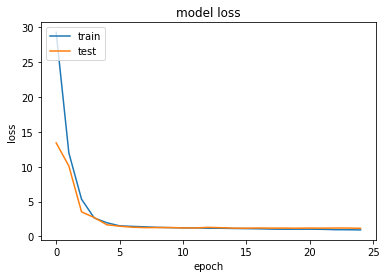

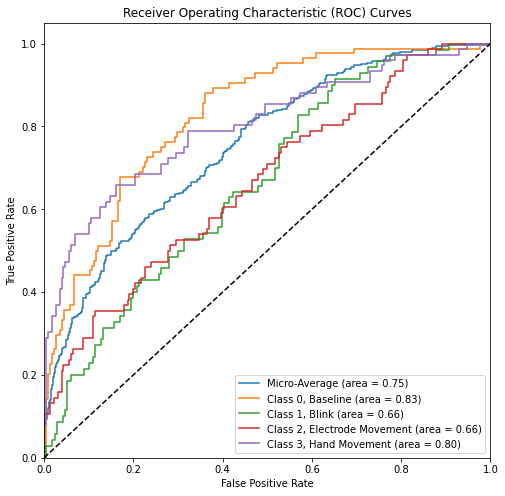

                    precision    recall  f1-score   support

          Baseline       0.52      0.68      0.59        84
             Blink       0.41      0.29      0.34        70
Electrode Movement       0.45      0.34      0.39        76
     Hand Movement       0.56      0.66      0.60        76

         micro avg       0.50      0.50      0.50       306
         macro avg       0.48      0.49      0.48       306
      weighted avg       0.49      0.50      0.49       306
       samples avg       0.50      0.50      0.50       306



In [18]:
from keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPool2D
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

# CNN
model.add(Conv2D(32, kernel_size=(4,4), activation='relu', padding='same', input_shape=(WIDTH, HEIGHT, 3)))
model.add(MaxPool2D(pool_size=(3,3)))
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(128, kernel_size=(2,2), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# ANN
model.add(Flatten())
model.add(Dense(1000, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=Adam(learning_rate=2e-4))

train(model, X_train, y_train, X_test, y_test, n_classes, epochs=25)